In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc

Using TensorFlow backend.
F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
embed_size = 0

In [5]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [12]:
#由于我们将计算一些单词嵌入，让我们定义一个函数，以便能够正确地运行我们的实验。我将在下面的函数中添加一些注释，以便更好地理解。
# 请注意，Kaggle数据集中嵌入了很多手套，我觉得使用基于Twitter文本进行训练的手套更合适。由于我们数据集中的注释由随意的、用户生成的短消息组成，因此使用的语义可能非常相似。因此，我们可能能够捕捉本质，并使用它来产生一个良好的准确的分数。
# 同样，我也使用了经过谷歌负面新闻文本语料库训练的Word2Vec嵌入，希望它的负面词汇能在我们的“有毒”上下文中更好地发挥作用。

In [27]:
def loadEmbeddingMatrix(typeToLoad):
    #根据Embedding的不同，从Kaggle加载不同的嵌入文件
    #我们要实验的矩阵
    if(typeToLoad=='glove'):
        EMBEDDING_FILE = '../input/glove.twitter.27B.25d.txt'
        embed_size = 25
    elif(typeToLoad=='word2vec'):
        word2vecDict = word2vec.KeyedVectors.load_word2vec_format('../../Quora/input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary=True)
        embed_size = 300
    elif(typeToLoad=='fasttext'):
        EMBEDDING_FILE='../input/wiki.simple.vec'
        embed_size = 300
    
    if(typeToLoad=='glove' or typeToLoad=='fasttext'):
        embeddings_index = dict()
        #通过遍历文件的每一行，将Embedding权重转移到字典中。
        f = open(EMBEDDING_FILE)
        for line in f:
            #split up line into an indexed array
            values = line.split()
            #first index is word
            word = values[0]
            #store the rest of the values in the array as a new array
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs #50 dimensions
        f.close()
        print('Loaded %s word vectors.' % len(embeddings_index))
    else:
        embeddings_index = dict()
        for word in word2vecDict.wv.vocab:
            embeddings_index[word] = word2vecDict.word_vec(word)
        print('Loaded %s word vectors.' % len(embeddings_index))
    
    gc.collect()
    #我们得到嵌入权值的均值和标准差，这样我们就可以保持
    #对于我们自己随机产生的权值的其余部分，同样的统计数据。
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    
    nb_words = len(tokenizer.word_index)
    #我们讲设置Embedding的尺寸为我们复制的预训练的维度
    #Embedding矩阵大小将为 词汇中词数 X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()
    
    #使用新创建的嵌入矩阵，我们将用两个矩阵中的单词填充它
    #我们自己的字典和加载预训练嵌入。
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
        i -= 1
        #然后我们看看这个词是否在GLove的字典里，如果是，得到相应的权重
        embedding_vector = embeddings_index.get(word)
        #并存储在Embedding矩阵中，我们稍后将用其进行训练。
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            embeddedCount += 1
    print('total embedded:', embeddedCount,'common words')
    
    del(embeddings_index)
    gc.collect()
    
    #最后，返回Embedding矩阵
    return embedding_matrix
    

In [28]:
#该函数将返回一个新的嵌入矩阵，
#该矩阵中包含了我们常用单词的预训练嵌入中加载的权重，
#以及随机初始化的数字，该矩阵中其余权重的均值和标准差相同。

In [29]:
#让我们继续，从Word2Vec加载第一个嵌入

In [30]:
embedding_matrix = loadEmbeddingMatrix('word2vec')

Loaded 3000000 word vectors.
total embedded: 66078 common words


In [31]:
embedding_matrix.shape

(210337, 300)

With the embedding weights, we can proceed to build a LSTM layer. The whole architecture is pretty much the same as the previous one I have done in the earlier kernel here, except that I have turned the LSTM into a bidirectional one, and added a dropout factor to it. 

We start off with defining our input layer. By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [32]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we use the "weights" parameter to indicate the use of the pretrained embedding weights we have loaded and the "trainable" parameter to tell Keras not to retrain the embedding layer.

In [33]:
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

Next, we pass it to a LSTM unit. But this time round, we will be using a Bidirectional LSTM instead because there are several kernels which shows a decent gain in accuracy by using Bidirectional LSTM.

How does Bidirectional LSTM work? 

![](https://i.imgur.com/jaKiP0S.png)

Imagine that the LSTM is split between 2 hidden states for each time step. As the sequence of words is being feed into the LSTM in a forward fashion, there's another reverse sequence that is feeding to the different hidden state at the same time. You might noticed later at the model summary that the output dimension of LSTM layer has doubled to 120 because 60 dimensions are used for forward, and another 60 are used for reverse.

The greatest advantage in using Bidirectional LSTM is that when it runs backwards you preserve information from the future and using the two hidden states combined, you are able in any point in time to preserve information from both past and future.


In [34]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Okay! With the LSTM behind us, we'll feed the output into the rest of the layers which we have done so in the previous kernel. 

In [35]:
x = GlobalMaxPool1D()(x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [36]:
x = Dropout(0.1)(x)

In [37]:
x = Dense(50, activation='relu')(x)

In [38]:
x = Dropout(0.1)(x)

In [39]:
x = Dense(6, activation='sigmoid')(x)

In [40]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [41]:
#在训练之前查看整个网络的架构是一个好主意，因为您不想把宝贵的时间浪费在错误的设置上。

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          63101100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

最后，我们启动了训练过程，目标是运行4个epoch，批大小为32。我们将训练和验证损失保存在一个变量中，这样我们可以查看是否存在过拟合。

In [43]:
#batch_size = 32
#epochs = 4
#hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

模型的训练将比Kaggle kenel所允许的要长。我已经预先运行过了，这就是你们应该大致看到的结果

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 2938s 20ms/step - loss: 0.0843 - acc: 0.9739 - val_loss: 0.0630 - val_acc: 0.9786

Epoch 2/4
143613/143613 [==============================] - 3332s 23ms/step - loss: 0.0573 - acc: 0.9805 - val_loss: 0.0573 - val_acc: 0.9803

Epoch 3/4
143613/143613 [==============================] - 3119s 22ms/step - loss: 0.0513 - acc: 0.9819 - val_loss: 0.0511 - val_acc: 0.9817

Epoch 4/4
143613/143613 [==============================] - 3137s 22ms/step - loss: 0.0477 - acc: 0.9827 - val_loss: 0.0498 - val_acc: 0.9820


In [44]:
#loadEmbeddingMatrix('word2vec')

with

In [45]:
#loadEmbeddingMatrix('glove') #for GLOVE or
#loadEmbeddingMatrix('fasttext') #for fasttext

加载来自不同来源的预训练嵌入。
为了我们的基准。我已经预运行了它并收集了所有的结果。

**GLOVE:**

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 2470s 17ms/step - loss: 0.1160 - acc: 0.9656 - val_loss: 0.0935 - val_acc: 0.9703

Epoch 2/4
143613/143613 [==============================] - 2448s 17ms/step - loss: 0.0887 - acc: 0.9721 - val_loss: 0.0800 - val_acc: 0.9737

Epoch 3/4
143613/143613 [==============================] - 2410s 17ms/step - loss: 0.0799 - acc: 0.9745 - val_loss: 0.0753 - val_acc: 0.9757

Epoch 4/4
143613/143613 [==============================] - 2398s 17ms/step - loss: 0.0753 - acc: 0.9760 - val_loss: 0.0724 - val_acc: 0.9768


**Fasttext:**

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 2800s 19ms/step - loss: 0.0797 - acc: 0.9757 - val_loss: 0.0589 - val_acc: 0.9795

Epoch 2/4
143613/143613 [==============================] - 2756s 19ms/step - loss: 0.0561 - acc: 0.9808 - val_loss: 0.0549 - val_acc: 0.9804

Epoch 3/4
143613/143613 [==============================] - 2772s 19ms/step - loss: 0.0507 - acc: 0.9819 - val_loss: 0.0548 - val_acc: 0.9811

Epoch 4/4
143613/143613 [==============================] - 2819s 20ms/step - loss: 0.0474 - acc: 0.9828 - val_loss: 0.0507 - val_acc: 0.9817


当然，同样的baseline模型不使用任何预先训练的嵌入，直接从之前的kenel中获得，除了我们运行了4个epochs:

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 5597s 39ms/step - loss: 0.0633 - acc: 0.9788 - val_loss: 0.0480 - val_acc: 0.9825

Epoch 2/4
143613/143613 [==============================] - 5360s 37ms/step - loss: 0.0448 - acc: 0.9832 - val_loss: 0.0464 - val_acc: 0.9828

Epoch 3/4
143613/143613 [==============================] - 5352s 37ms/step - loss: 0.0390 - acc: 0.9848 - val_loss: 0.0470 - val_acc: 0.9829

Epoch 4/4
129984/143613 [==============================] - 5050s 37ms/step - loss: 0.0386 - acc: 0.9858 - val_loss: 0.0478 - val_acc: 0.9830

如果我们把损失画成图表就容易多了

In [46]:
all_losses = {
'word2vec_loss': [0.084318213647104789,
  0.057314205012433353,
  0.051338302593577821,
  0.047672802178572039],
 'word2vec_val_loss': [0.063002561892695971,
  0.057253835496480658,
  0.051085027624451551,
  0.049801279793734249],
'glove_loss': [0.11598931579683543,
  0.088738223480436862,
  0.079895263566000005,
  0.075343037429358703],
 'glove_val_loss': [0.093467933030432285,
  0.080007083813922117,
  0.075349041991106688,
  0.072366507668134517],
 'fasttext_loss': [0.079714499498945865,
  0.056074704045674786,
  0.050703874653286324,
  0.047420131195761134],
 'fasttext_val_loss': [0.058888281775148932,
  0.054906051694414926,
  0.054768857866843601,
  0.050697043558286421],
 'baseline_loss': [0.063304489498915865,
  0.044864004045674786,
  0.039013874651286124,
  0.038630130175761134],
 'baseline_val_loss': [0.048044281075148932,
  0.046414051594414926,
  0.047058757860843601,
  0.047886043558285421]
}

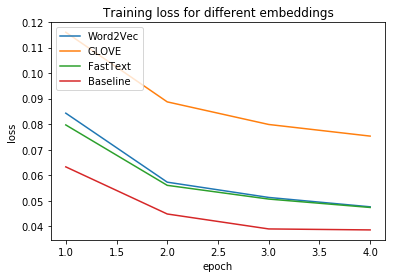

In [47]:
#f, ax = plt.subplots(1)
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_loss'])
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText','Baseline'], loc='upper left')
plt.show()

看起来baseline的训练损失是最小的。但是在我们结束这个案例并选择baseline模型作为赢家之前，这个情节并不能说明全部，因为在baseline模型中似乎存在一些过拟合。<br>从第二阶段开始，随着验证损失大于训练损失，过拟合开始出现

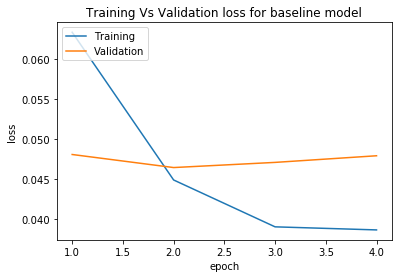

In [48]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['baseline_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Training Vs Validation loss for baseline model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

剩下的呢?让我们画出所有的训练/验证损失图来进行比较。

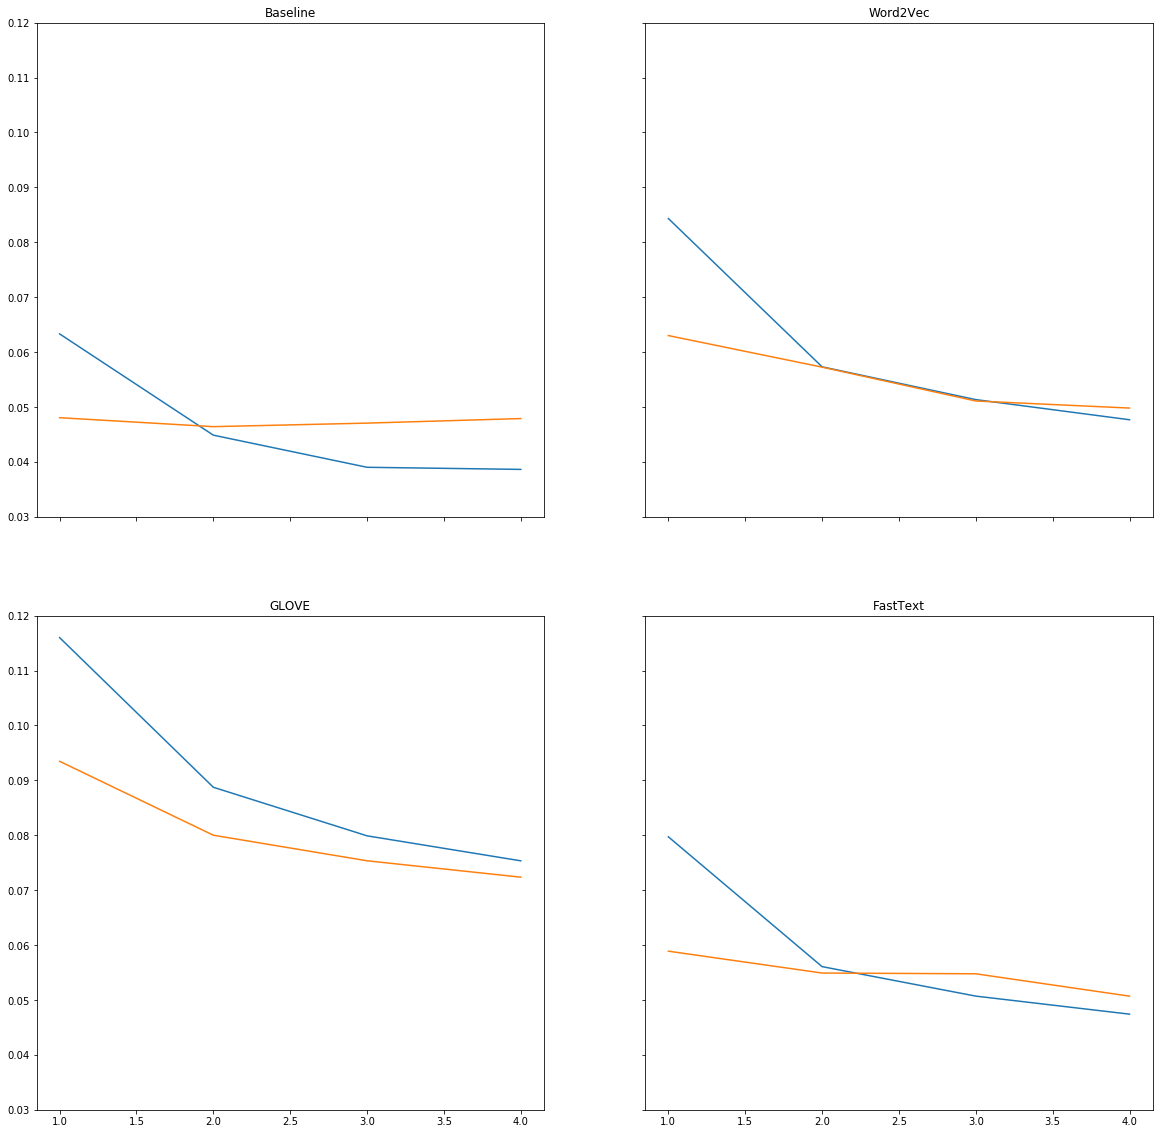

In [49]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(20, 20))

plt.title('Training Vs Validation loss for all embeddings')
ax1.plot(epochRange,all_losses['baseline_loss'])
ax1.plot(epochRange,all_losses['baseline_val_loss'])
ax1.set_title('Baseline')
ax1.set_ylim(0.03, 0.12)

ax2.plot(epochRange,all_losses['word2vec_loss'])
ax2.plot(epochRange,all_losses['word2vec_val_loss'])
ax2.set_title('Word2Vec')
ax2.set_ylim(0.03, 0.12)

ax3.plot(epochRange,all_losses['glove_loss'])
ax3.plot(epochRange,all_losses['glove_val_loss'])
ax3.set_title('GLOVE')
ax3.set_ylim(0.03, 0.12)


ax4.plot(epochRange,all_losses['fasttext_loss'])
ax4.plot(epochRange,all_losses['fasttext_val_loss'])
ax4.set_title('FastText')
ax4.set_ylim(0.03, 0.12)

plt.show()

考虑到所有的损失，很容易看出哪个是最好的选择。虽然这只手套看起来仍有一些空间，但与其他手套相比，它的损耗是很大的。另一方面，Word2Vec和FastText分别在第4和第3个时代开始过度匹配。那么你会选择哪一个作为赢家呢?在我看来，仍然是基线模型。
那么问题出在哪里呢?难道预先训练的嵌入不应该改进吗?因为它是用来自大量特征丰富语料库的数十亿单词进行训练的。
一种可能性是，这些预先训练的嵌入没有针对文本i进行训练

In [50]:
wordCount = {'word2vec':66078,'glove':81610,'fasttext':59613,'baseline':210337}

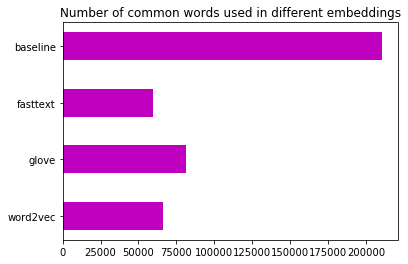

In [51]:
ind = np.arange(0,4,1)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.title('Number of common words used in different embeddings')
embNames = list(wordCount.keys())
embVals = list(wordCount.values())
plt.barh(ind,embVals,align='center', height=0.5, color='m',tick_label=embNames)
plt.show()

从上面的条形图中可以明显看出，baseline包含的单词最多<br>
因为嵌入层是使用数据集中的单词进行训练的。<br>重要的结论是，预先训练的嵌入只包含大约60,000个共同的单词(少于基线的一半)，
<br>而由这些预先训练的权重构建的嵌入层不能很好地表示训练数据。
<br>虽然构建您自己的嵌入需要更长的时间，但它可能是值得的，因为它是专门为您的上下文构建的。

这就完成了这个内核!我希望有人在这个内核中学到了一些东西。
<br>如果你发现了一个错误，请在下面的评论中告诉我。
<br>感谢阅读，祝比赛顺利!

**TODO:**
1. There are many pretrained embeddings in Kaggle, and they are trained in different contexts of text corpus. You could try out other pretrained embeddings that is more suitable to the dataset in our competition.
2. Introduce LSTM drop out and recurrent drop out in baseline model, and tune the dropout rate to decrease overfitting.